In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tanjimtaharataurpa/bangla-math-entity-recognition")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bangla-math-entity-recognition


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import os
import time
import re
import random
import shap
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
dataset_path_bangla = "/kaggle/input/bangla-math-entity-recognition/Bangla Mathematical Entity Recognition Dataset final.csv"
dataset_path_english= "/kaggle/input/bangla-math-entity-recognition/Bangla Mathematical Entity Recognition Dataset final english.csv"

In [5]:
# Load the dataset into a DataFrame
dataset_bangla = pd.read_csv(dataset_path_bangla)
dataset_bangla.head()


,0,এক আর দুই যোগ করলে তিন হবে।,"এক, দুই, তিন",Number
0,1,এক আর দুই যোগ করলে তিন হবে।,যোগ,Operator
1,3,এক আর দুই যোগ করলে তিন হবে।,আর করলে হবে,Others
2,4,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,"পাঁচ, একশ বিশ",Number
3,5,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,ফ্যাক্টরিয়ালের,Operator
4,7,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,মান,Others


In [6]:
dataset_bangla.isnull().sum()

0                              0
এক আর দুই যোগ করলে তিন হবে।    0
এক, দুই, তিন                   0
Number                         0
dtype: int64

In [7]:
dataset_bangla.duplicated().sum()

0

In [8]:
dataset_bangla.dtypes

0                               int64
এক আর দুই যোগ করলে তিন হবে।    object
এক, দুই, তিন                   object
Number                         object
dtype: object

In [9]:
df1 = dataset_bangla.copy()

df1.columns = ['ID', 'Sentence', 'Math Entity', 'Label']

df1.head()

,ID,Sentence,Math Entity,Label
0,1,এক আর দুই যোগ করলে তিন হবে।,যোগ,Operator
1,3,এক আর দুই যোগ করলে তিন হবে।,আর করলে হবে,Others
2,4,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,"পাঁচ, একশ বিশ",Number
3,5,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,ফ্যাক্টরিয়ালের,Operator
4,7,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,মান,Others


In [10]:
print(df1['Sentence'].iloc[5])

ঋণাত্মক সংখ্যার বর্গমূল হল যৌগিক সংখ্যা।


In [11]:
dataset_english = pd.read_csv(dataset_path_english)
dataset_english.head()

,0,Adding one and two makes three.,"One, two, three",Number
0,1,Adding one and two makes three.,added,Operator
1,3,Adding one and two makes three.,And if you do,Others
2,4,The value of the factorial of five is one hun...,"Five, one hundred and twenty",Number
3,5,The value of the factorial of five is one hun...,of the factorial,Operator
4,7,The value of the factorial of five is one hun...,value,Others


In [12]:
dataset_english.isnull().sum()


0                                  0
Adding one and two makes three.    0
 One, two, three                   0
 Number                            0
dtype: int64

In [13]:
dataset_english.duplicated().sum()

0

In [14]:
dataset_english.dtypes

0                                   int64
Adding one and two makes three.    object
 One, two, three                   object
 Number                            object
dtype: object

In [15]:
df2 = dataset_english.copy()

df2.columns = ['ID', 'Sentence', 'Math Entity', 'Label']

df2.head()

,ID,Sentence,Math Entity,Label
0,1,Adding one and two makes three.,added,Operator
1,3,Adding one and two makes three.,And if you do,Others
2,4,The value of the factorial of five is one hun...,"Five, one hundred and twenty",Number
3,5,The value of the factorial of five is one hun...,of the factorial,Operator
4,7,The value of the factorial of five is one hun...,value,Others


In [16]:
print(df2['Sentence'].iloc[5])

 The square root of a negative number is a composite number.


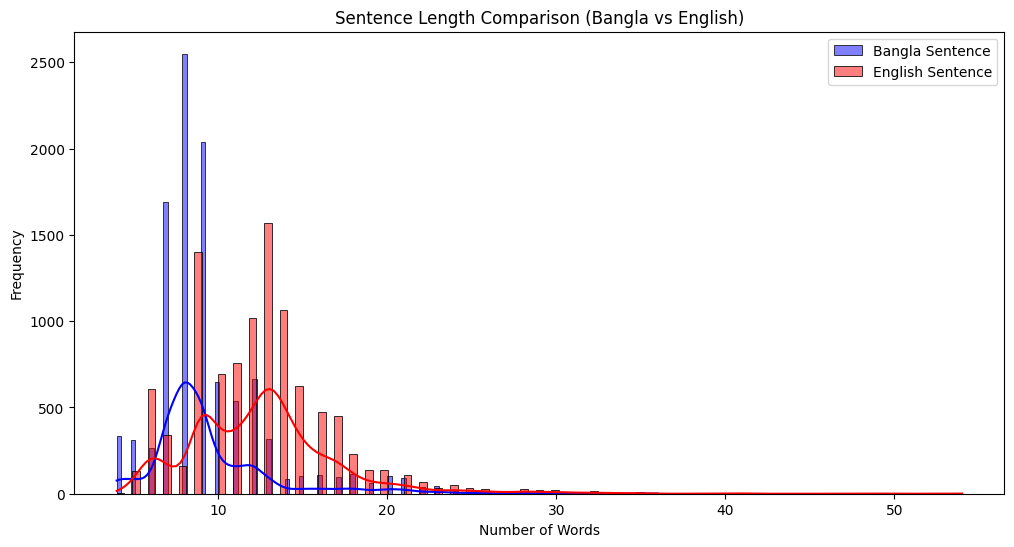

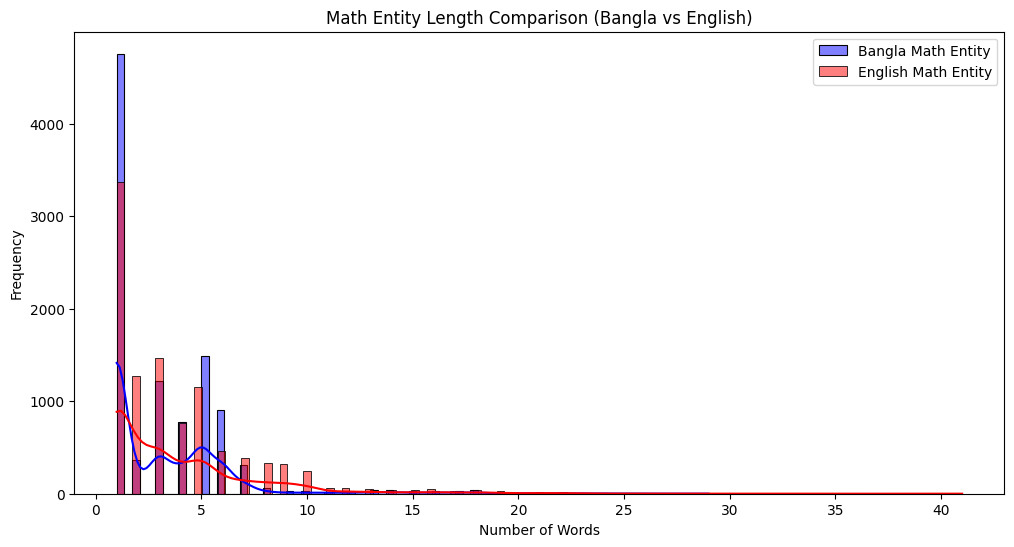

([('বর গম', 2538),
  ('গম দশম', 909),
  ('দশম এক', 612),
  ('দশম ছয়', 591),
  ('নব বই', 579),
  ('করল হব', 559),
  ('দশম আট', 558),
  ('যখন একশ', 545),
  ('আমর যখন', 483),
  ('দশম যখন', 444)],
 [('বর গম দশম', 909),
  ('বর গম ইশ', 288),
  ('গম ইশ দশম', 270),
  ('টর এক দশম', 237),
  ('যখন একশ আর', 233),
  ('তর বর গম', 231),
  ('বইয় বর গম', 225),
  ('নব বইয় বর', 210),
  ('আমর দশম যখন', 183),
  ('এর বর গম', 180)],
 [('hundred and', 2820),
  ('we get', 2600),
  ('when we', 2543),
  ('the square', 2539),
  ('square root', 2538),
  ('root of', 2538),
  ('value of', 2511),
  ('of the', 2142),
  ('the value', 2118),
  ('one hundred', 1920)],
 [('square root of', 2538),
  ('the square root', 2535),
  ('the value of', 2118),
  ('value of the', 2037),
  ('of the square', 1041),
  ('the factorial of', 1002),
  ('of the factorial', 978),
  ('when we divide', 960),
  ('one hundred and', 954),
  ('when we subtract', 660)])

In [17]:
# Method to calculate word count 
def calculate_word_count(text):
    return len(text.split())

# Function to get n-grams from text
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Calculate Sentence and Token length using the calculate word count
df1['sentence_length'] = df1['Sentence'].apply(calculate_word_count)
df1['math_entity_length'] = df1['Math Entity'].apply(calculate_word_count)

df2['sentence_length'] = df2['Sentence'].apply(calculate_word_count)
df2['math_entity_length'] = df2['Math Entity'].apply(calculate_word_count)

# Plotting the histogram for headline lengths
plt.figure(figsize=(12, 6))
sns.histplot(df1['sentence_length'], label='Bangla Sentence', color='blue', kde=True)
sns.histplot(df2['sentence_length'], label='English Sentence', color='red', kde=True)
plt.title('Sentence Length Comparison (Bangla vs English)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plotting the histogram for content lengths
plt.figure(figsize=(12, 6))
sns.histplot(df1['math_entity_length'], label='Bangla Math Entity', color='blue', kde=True)
sns.histplot(df2['math_entity_length'], label='English Math Entity', color='red', kde=True)
plt.title('Math Entity Length Comparison (Bangla vs English)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Now, let's extract and display the bigrams and trigrams from the Sentences of both datasets
top_bigrams_bangla = get_top_ngrams(df1['Sentence'], n=10, ngram_range=(2, 2))
top_trigrams_bangla = get_top_ngrams(df1['Sentence'], n=10, ngram_range=(3, 3))

top_bigrams_english = get_top_ngrams(df2['Sentence'], n=10, ngram_range=(2, 2))
top_trigrams_english = get_top_ngrams(df2['Sentence'], n=10, ngram_range=(3, 3))

top_bigrams_bangla, top_trigrams_bangla, top_bigrams_english, top_trigrams_english


In [18]:
bng_df = df1.copy()
eng_df = df2.copy()

In [19]:
bng_df.head()

,ID,Sentence,Math Entity,Label,sentence_length,math_entity_length
0,1,এক আর দুই যোগ করলে তিন হবে।,যোগ,Operator,7,1
1,3,এক আর দুই যোগ করলে তিন হবে।,আর করলে হবে,Others,7,3
2,4,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,"পাঁচ, একশ বিশ",Number,5,3
3,5,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,ফ্যাক্টরিয়ালের,Operator,5,1
4,7,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,মান,Others,5,1


In [20]:
print(bng_df.columns)
print(eng_df.columns)


Index(['ID', 'Sentence', 'Math Entity', 'Label', 'sentence_length',
       'math_entity_length'],
      dtype='object')
Index(['ID', 'Sentence', 'Math Entity', 'Label', 'sentence_length',
       'math_entity_length'],
      dtype='object')


In [21]:
bng_df = bng_df.drop(columns=["sentence_length", "math_entity_length"])
eng_df = eng_df.drop(columns=["sentence_length", "math_entity_length"])


In [22]:
eng_df.head()

,ID,Sentence,Math Entity,Label
0,1,Adding one and two makes three.,added,Operator
1,3,Adding one and two makes three.,And if you do,Others
2,4,The value of the factorial of five is one hun...,"Five, one hundred and twenty",Number
3,5,The value of the factorial of five is one hun...,of the factorial,Operator
4,7,The value of the factorial of five is one hun...,value,Others


In [23]:
dataset = pd.merge(bng_df, eng_df, on='ID', suffixes=('_bangla', '_english'))
dataset.head()

,ID,Sentence_bangla,Math Entity_bangla,Label_bangla,Sentence_english,Math Entity_english,Label_english
0,1,এক আর দুই যোগ করলে তিন হবে।,যোগ,Operator,Adding one and two makes three.,added,Operator
1,3,এক আর দুই যোগ করলে তিন হবে।,আর করলে হবে,Others,Adding one and two makes three.,And if you do,Others
2,4,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,"পাঁচ, একশ বিশ",Number,The value of the factorial of five is one hun...,"Five, one hundred and twenty",Number
3,5,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,ফ্যাক্টরিয়ালের,Operator,The value of the factorial of five is one hun...,of the factorial,Operator
4,7,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,মান,Others,The value of the factorial of five is one hun...,value,Others


In [24]:
print(dataset.columns)


Index(['ID', 'Sentence_bangla', 'Math Entity_bangla', 'Label_bangla',
       'Sentence_english', 'Math Entity_english', 'Label_english'],
      dtype='object')


In [25]:
from transformers import AutoTokenizer

# Load the mBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

# Combine sentences with proper [SEP] token handling
dataset['Combined_Sentence'] = dataset.apply(
    lambda row: tokenizer.sep_token.join([row['Sentence_bangla'], row['Sentence_english']]), axis=1
)

dataset['Combined_Entity'] = dataset.apply(
    lambda row: tokenizer.sep_token.join([row['Math Entity_bangla'], row['Math Entity_english']]), axis=1
)

# Tokenize combined sentences and entities
encoding = tokenizer(
    dataset['Combined_Sentence'].tolist(),  # Using the combined sentences column
    padding=True,  # Ensures all sequences have the same length
    truncation=True,
    return_tensors="pt"
)

# Tokenize 'Combined_Entity' as well:
entity_encoding = tokenizer(
    dataset['Combined_Entity'].tolist(),  # Tokenizing the combined entities
    padding=True, 
    truncation=True,
    return_tensors="pt"
)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [26]:
dataset.head()

,ID,Sentence_bangla,Math Entity_bangla,Label_bangla,Sentence_english,Math Entity_english,Label_english,Combined_Sentence,Combined_Entity
0,1,এক আর দুই যোগ করলে তিন হবে।,যোগ,Operator,Adding one and two makes three.,added,Operator,এক আর দুই যোগ করলে তিন হবে।[SEP]Adding one and...,যোগ[SEP] added
1,3,এক আর দুই যোগ করলে তিন হবে।,আর করলে হবে,Others,Adding one and two makes three.,And if you do,Others,এক আর দুই যোগ করলে তিন হবে।[SEP]Adding one and...,আর করলে হবে[SEP] And if you do
2,4,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,"পাঁচ, একশ বিশ",Number,The value of the factorial of five is one hun...,"Five, one hundred and twenty",Number,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।[SEP] The va...,"পাঁচ, একশ বিশ[SEP] Five, one hundred and twenty"
3,5,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,ফ্যাক্টরিয়ালের,Operator,The value of the factorial of five is one hun...,of the factorial,Operator,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।[SEP] The va...,ফ্যাক্টরিয়ালের[SEP] of the factorial
4,7,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।,মান,Others,The value of the factorial of five is one hun...,value,Others,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।[SEP] The va...,মান[SEP] value


In [27]:
# Drop the specified columns
dataset.drop(columns=['Sentence_bangla', 'Math Entity_bangla', 'Sentence_english', 'Math Entity_english', 'Label_english'], inplace=True)

dataset.tail()


,ID,Label_bangla,Combined_Sentence,Combined_Entity
10276,13708,Number,আমরা একশো ঊনষাট পাই যখন একশো আর ঊনষা...,"একশো ঊনষাট , একশো, ঊনষাট[SEP] One hundred an..."
10277,13709,Operator,আমরা একশো ঊনষাট পাই যখন একশো আর ঊনষা...,যোগ[SEP] added
10278,13711,Others,আমরা একশো ঊনষাট পাই যখন একশো আর ঊনষা...,আমরা পাই যখন আর করি[SEP] We get when ...
10279,13712,Number,আমরা একশো ষাট পাই যখন একশো আর ষাট য...,"একশো ষাট, একশো, ষাট [SEP] One hundred and sixt..."
10280,13713,Operator,আমরা একশো ষাট পাই যখন একশো আর ষাট য...,যোগ[SEP] added


In [28]:
from sklearn.preprocessing import LabelEncoder

# Rename the column
dataset.rename(columns={'Label_bangla': 'Label'}, inplace=True)

# Apply label encoding
le = LabelEncoder()
dataset['Label'] = le.fit_transform(dataset['Label'])


In [29]:
# Reorder the columns
dataset = dataset[['ID', 'Combined_Sentence', 'Combined_Entity', 'Label']]

dataset.head()


,ID,Combined_Sentence,Combined_Entity,Label
0,1,এক আর দুই যোগ করলে তিন হবে।[SEP]Adding one and...,যোগ[SEP] added,2
1,3,এক আর দুই যোগ করলে তিন হবে।[SEP]Adding one and...,আর করলে হবে[SEP] And if you do,3
2,4,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।[SEP] The va...,"পাঁচ, একশ বিশ[SEP] Five, one hundred and twenty",1
3,5,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।[SEP] The va...,ফ্যাক্টরিয়ালের[SEP] of the factorial,2
4,7,পাঁচের ফ্যাক্টরিয়ালের মান একশ বিশ।[SEP] The va...,মান[SEP] value,3


In [30]:
# Define Dataset Class
class MathEntityDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence = row['Combined_Sentence']
        entity = row['Combined_Entity']
        label = row['Label']  # Directly use the pre-encoded label

        # Tokenize the input without return_overflowing_tokens
        inputs = self.tokenizer(
            text=sentence,
            text_pair=entity,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",  # Padding to the max length
            truncation=True,  # Truncating to the max length
            return_tensors="pt"
        )

        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(label, dtype=torch.long),  # Use the label directly
        }

# Dataset Splitting
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Dataset Objects
MAX_LEN = 128
train_dataset = MathEntityDataset(train_df, tokenizer, MAX_LEN)
val_dataset = MathEntityDataset(val_df, tokenizer, MAX_LEN)
test_dataset = MathEntityDataset(test_df, tokenizer, MAX_LEN)

# DataLoader
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Print to confirm
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 7401
Validation dataset size: 823
Test dataset size: 2057


In [35]:
from transformers import DistilBertForSequenceClassification, get_scheduler

# Load pre-trained DistilBERT with classification head
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=len(le.classes_),  # Use 'le.classes_' instead of 'label_encoder.classes_'
)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
EPOCHS = 20

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Scheduler setup
num_training_steps = len(train_loader) * EPOCHS  # Total training steps
num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup steps

scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)


In [37]:
# Training Loop
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    all_labels = []
    all_preds = []

    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        loss.backward()
        optimizer.step()

    scheduler.step()

    precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return total_loss / len(data_loader), correct_predictions.double() / len(data_loader.dataset), precision, recall, f1

# Validation Loop
def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return total_loss / len(data_loader), correct_predictions.double() / len(data_loader.dataset), precision, recall, f1

# Lists to store metrics
train_losses, train_accuracies, train_precisions, train_recalls, train_f1s = [], [], [], [], []
val_losses, val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], [], []

# Training Loop
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    train_loss, train_acc, train_precision, train_recall, train_f1 = train_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss, val_acc, val_precision, val_recall, val_f1 = eval_model(model, val_loader, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc.cpu().numpy())  
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc.cpu().numpy())  
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")



Epoch 1/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 1.3964, Train Accuracy: 0.2129
Val Loss: 1.3974, Val Accuracy: 0.2880

Epoch 2/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 1.3845, Train Accuracy: 0.2713
Val Loss: 1.3740, Val Accuracy: 0.3062

Epoch 3/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 1.3417, Train Accuracy: 0.3560
Val Loss: 1.2983, Val Accuracy: 0.4204

Epoch 4/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 1.2041, Train Accuracy: 0.4516
Val Loss: 1.1067, Val Accuracy: 0.5383

Epoch 5/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.9409, Train Accuracy: 0.7019
Val Loss: 0.7845, Val Accuracy: 0.8591

Epoch 6/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.6296, Train Accuracy: 0.9191
Val Loss: 0.4536, Val Accuracy: 0.9757

Epoch 7/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.3544, Train Accuracy: 0.9800
Val Loss: 0.2213, Val Accuracy: 0.9793

Epoch 8/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.1921, Train Accuracy: 0.9870
Val Loss: 0.1202, Val Accuracy: 0.9915

Epoch 9/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.1149, Train Accuracy: 0.9922
Val Loss: 0.0728, Val Accuracy: 0.9951

Epoch 10/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.0759, Train Accuracy: 0.9935
Val Loss: 0.0479, Val Accuracy: 0.9951

Epoch 11/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.0535, Train Accuracy: 0.9939
Val Loss: 0.0343, Val Accuracy: 0.9951

Epoch 12/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.0403, Train Accuracy: 0.9938
Val Loss: 0.0258, Val Accuracy: 0.9951

Epoch 13/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.0314, Train Accuracy: 0.9939
Val Loss: 0.0203, Val Accuracy: 0.9951

Epoch 14/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.0253, Train Accuracy: 0.9942
Val Loss: 0.0161, Val Accuracy: 0.9964

Epoch 15/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.0209, Train Accuracy: 0.9959
Val Loss: 0.0131, Val Accuracy: 1.0000

Epoch 16/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.0170, Train Accuracy: 0.9989
Val Loss: 0.0102, Val Accuracy: 1.0000

Epoch 17/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.0125, Train Accuracy: 0.9996
Val Loss: 0.0063, Val Accuracy: 1.0000

Epoch 18/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.0087, Train Accuracy: 0.9999
Val Loss: 0.0043, Val Accuracy: 1.0000

Epoch 19/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.0064, Train Accuracy: 0.9999
Val Loss: 0.0031, Val Accuracy: 1.0000

Epoch 20/20


Training:   0%|          | 0/463 [00:00<?, ?it/s]

Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.0051, Train Accuracy: 0.9999
Val Loss: 0.0024, Val Accuracy: 1.0000



Final Training Results:
Train Loss: 0.0051
Train Accuracy: 99.99%
Train Precision: 0.9999
Train Recall: 0.9999
Train F1 Score: 0.9999

Final Validation Results:
Validation Loss: 0.0024
Validation Accuracy: 100.00%
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000


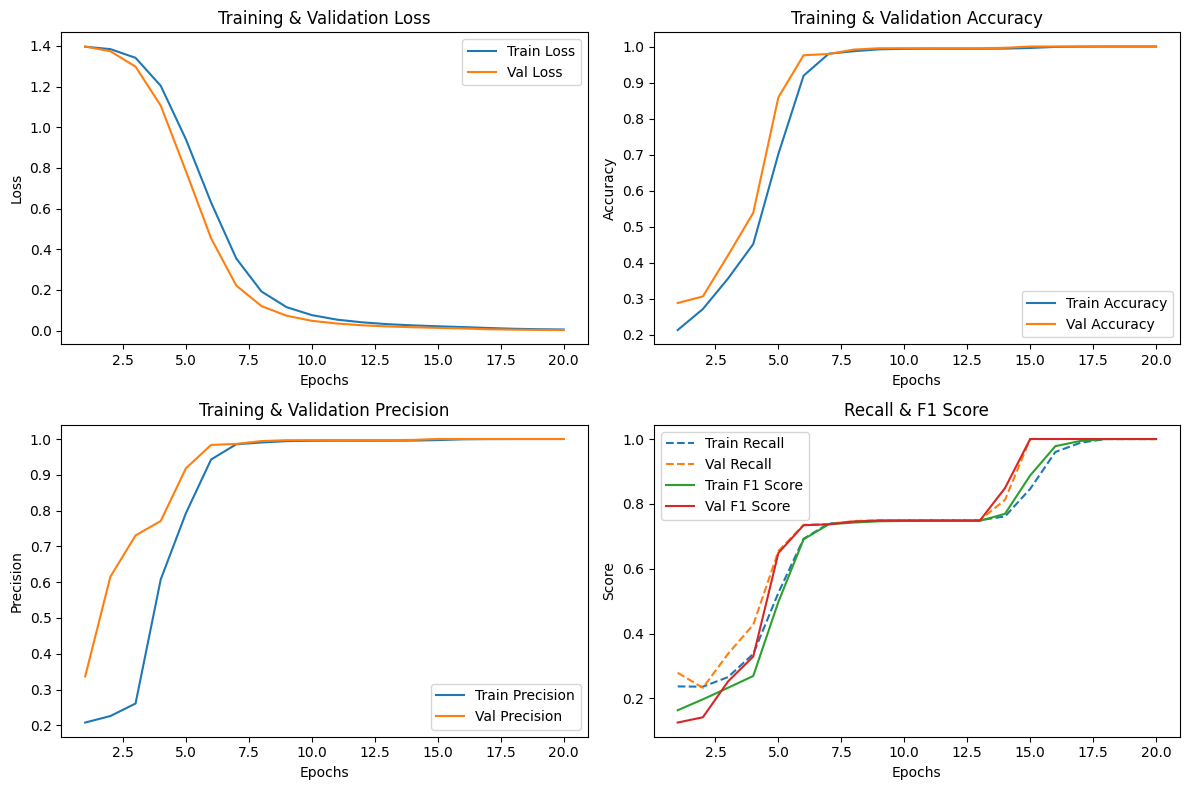

In [38]:
# Print final results
print("\nFinal Training Results:")
print(f"Train Loss: {train_losses[-1]:.4f}")
print(f"Train Accuracy: {train_accuracies[-1] * 100:.2f}%")
print(f"Train Precision: {train_precisions[-1]:.4f}")
print(f"Train Recall: {train_recalls[-1]:.4f}")
print(f"Train F1 Score: {train_f1s[-1]:.4f}")

print("\nFinal Validation Results:")
print(f"Validation Loss: {val_losses[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracies[-1] * 100:.2f}%")
print(f"Validation Precision: {val_precisions[-1]:.4f}")
print(f"Validation Recall: {val_recalls[-1]:.4f}")
print(f"Validation F1 Score: {val_f1s[-1]:.4f}")

# Plot Training Curves
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 8))

# Loss Curve
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy Curve
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# Precision Curve
plt.subplot(2, 2, 3)
plt.plot(epochs_range, train_precisions, label="Train Precision")
plt.plot(epochs_range, val_precisions, label="Val Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Training & Validation Precision")
plt.legend()

# Recall & F1 Score Curve
plt.subplot(2, 2, 4)
plt.plot(epochs_range, train_recalls, label="Train Recall", linestyle="--")
plt.plot(epochs_range, val_recalls, label="Val Recall", linestyle="--")
plt.plot(epochs_range, train_f1s, label="Train F1 Score")
plt.plot(epochs_range, val_f1s, label="Val F1 Score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Recall & F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


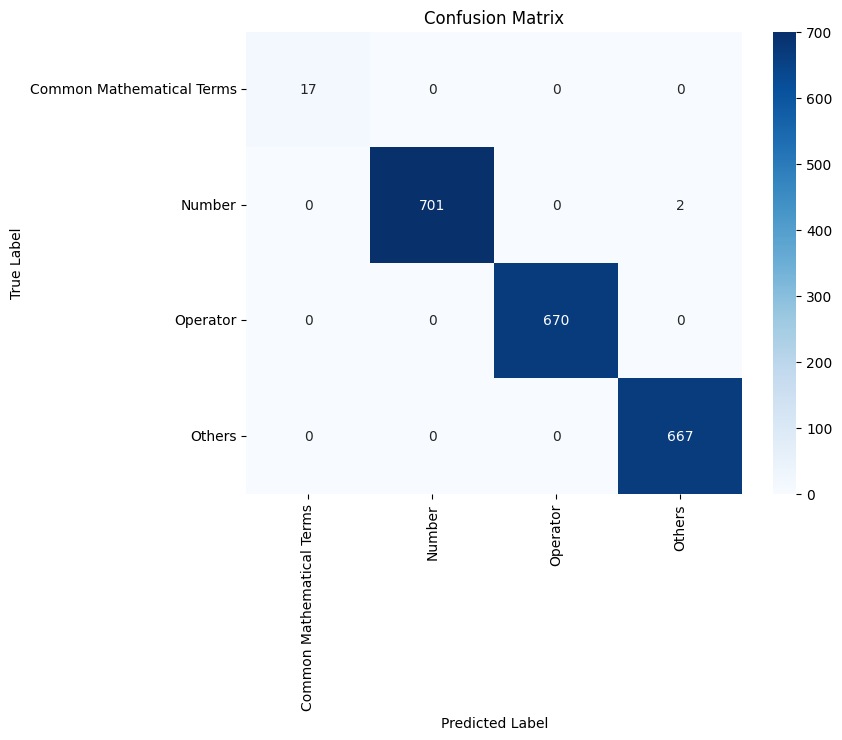

In [39]:
from sklearn.metrics import confusion_matrix

# Function to evaluate the model and get predictions
def get_predictions(model, data_loader, device):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()  # Get labels

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()  # Get predictions

            predictions.extend(preds)
            true_labels.extend(labels)

    return predictions, true_labels

# Get predictions and true labels from test set
predictions, true_labels = get_predictions(model, test_loader, device)

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [40]:
# Define paths
model_save_path = "./math_entity_recognition_DistilBERT"
tokenizer_save_path = "./math_entity_recognition_tokenizer"

# Save model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)


('./math_entity_recognition_tokenizer/tokenizer_config.json',
 './math_entity_recognition_tokenizer/special_tokens_map.json',
 './math_entity_recognition_tokenizer/vocab.txt',
 './math_entity_recognition_tokenizer/added_tokens.json',
 './math_entity_recognition_tokenizer/tokenizer.json')

In [43]:
import shutil

# Compress the saved directories
shutil.make_archive("math_entity_recognition_DistilBERT", 'zip', model_save_path)
shutil.make_archive("math_entity_recognition_tokenizer", 'zip', tokenizer_save_path)

'/kaggle/working/math_entity_recognition_tokenizer.zip'

In [45]:
# Use the model and tokenizer paths directly
model_path = "/kaggle/working/math_entity_recognition_DistilBERT"
tokenizer_path = "/kaggle/working/math_entity_recognition_tokenizer"

model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# Move the model to the appropriate device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


In [46]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Evaluation on the test set
def evaluate_classification_metrics(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Classification report
    class_report = classification_report(all_labels, all_preds, target_names=le.classes_.astype(str))


    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"\nClassification Report:\n{class_report}")
    
    return accuracy, precision, recall, f1, class_report

# Call the evaluation function on the test set
test_accuracy, test_precision, test_recall, test_f1, class_report = evaluate_classification_metrics(model, test_loader, device)



Testing:   0%|          | 0/129 [00:00<?, ?it/s]

Accuracy: 0.9990277102576568
Precision: 0.9990306169534484
Recall: 0.9990277102576568
F1 Score: 0.9990277455053787

Classification Report:
                           precision    recall  f1-score   support

Common Mathematical Terms       1.00      1.00      1.00        17
                   Number       1.00      1.00      1.00       703
                 Operator       1.00      1.00      1.00       670
                   Others       1.00      1.00      1.00       667

                 accuracy                           1.00      2057
                macro avg       1.00      1.00      1.00      2057
             weighted avg       1.00      1.00      1.00      2057



In [47]:
print(dataset['Combined_Sentence'].iloc[0])
print(dataset['Combined_Sentence'].iloc[5])

এক আর দুই যোগ করলে তিন হবে।[SEP]Adding one and two makes three.
ঋণাত্মক সংখ্যার বর্গমূল হল যৌগিক সংখ্যা।[SEP] The square root of a negative number is a composite number.


In [49]:
import shap

# Ensure the model is in evaluation mode
model.eval()

# Define a wrapper function for the model to predict probabilities
def predict_proba(texts):
    """
    Wrapper for predicting probabilities for a list of texts using the model.
    Args:
    - texts (list of str): List of input texts.

    Returns:
    - np.array: Predicted probabilities for each class.
    """
    # Ensure texts is a list (convert from NumPy array if necessary)
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()  # Convert NumPy array to list
    
    inputs = tokenizer.batch_encode_plus(
        texts,
        max_length=100,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Perform model inference
    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = output.logits  # Extract logits from the SequenceClassifierOutput
        probabilities = torch.softmax(logits, dim=1).cpu().numpy()

    return probabilities

# Load the tokenizer and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize SHAP explainer with background data
background_texts = df1["Sentence"].iloc[:2].tolist()  # Use first 2 rows for background
background = tokenizer.batch_encode_plus(
    background_texts,
    max_length=100,
    truncation=True,
    padding="max_length",
    return_tensors="pt"
)
background_input_ids = background["input_ids"].to(device)
background_attention_mask = background["attention_mask"].to(device)

# Initialize SHAP explainer
explainer = shap.Explainer(
    predict_proba,
    masker=shap.maskers.Text(tokenizer)
)

# Texts to explain (the sentences you want to explain)
texts_to_explain = df1["Sentence"].iloc[2:4].tolist()
#texts_to_explain = dataset["Combined_Sentence"].iloc[1]

# Explain the predictions
shap_values = explainer(texts_to_explain)

# Visualize the explanations
shap.plots.text(shap_values[0])  # Visualization for the first text


In [53]:
from lime.lime_text import LimeTextExplainer

# Ensure the model is in evaluation mode
model.eval()

# Prediction function for LIME (using CPU to save GPU memory)
def predict_proba_lime(texts):
    model.cpu()  # Move the model to CPU for inference
    inputs = tokenizer.batch_encode_plus(
        texts,
        max_length=50,  # Reduce max_length for memory efficiency
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = output.logits.numpy()
        probabilities = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)  # Softmax for probabilities

    model.to(device)  # Move the model back to GPU for other tasks
    return probabilities

# Load the tokenizer and model
tokenizer = tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize LIME Text Explainer
explainer = LimeTextExplainer(class_names=["Number", "Operator", "Common Mathematical Terms", "Others"])

# Sample text to explain)
sample_text = "ঋণাত্মক সংখ্যার বর্গমূল হল যৌগিক সংখ্যা।"
#"অনেকেই এককে মৌলিক সংখ্যা ভেবে ভূল করে থাকেন।"

# Generate explanation with optimizations
exp = explainer.explain_instance(
    sample_text[:200],  # Truncate input to 200 characters
    predict_proba_lime,
    num_features=10,  # Number of top features to show
    top_labels=2,     # Number of top labels to show
    num_samples=500   # Number of perturbations (reduce for faster results)
)

# Visualize the explanation in a notebook
exp.show_in_notebook(text=True)
